In [1]:
# Python 2 & 3 Compatibility
from __future__ import print_function, division

# Necessary imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from diagnostic_plots import diagnostic_plots

import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.linear_model import  LassoCV, RidgeCV, ElasticNetCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

%matplotlib inline

/home/pnietoramos/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#Merging all csv:
# Income_crime_FINAL1.csv; Income_crime_FINAL2.csv
df_inc = pd.read_csv("Income_crime_FINAL1.csv", index_col=0)
df_inc_2 = pd.read_csv("Income_crime_FINAL2.csv", index_col=0)
df_cities = pd.read_csv("Cities_things_rent_FINAL_MOD.csv", index_col=0)
df_inc = pd.concat([df_inc, df_inc_2])
df_all = df_cities.merge(df_inc, how = 'inner', on = ["City", "State"])
df_all.head(1)
#df_inc.to_csv("Income_ALL.csv")

,City,State,Population_2017,Area,Pop_density,Things_to_do,State_code,Price_1br,median_income,murders_2016_pro10e5,assaults_2016_pro10e5
0,Los Angeles,California,3999759,1213.9,3276,624,CA,1361,"54,432",7.3,396.1


In [3]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284 entries, 0 to 283
Data columns (total 11 columns):
City                     284 non-null object
State                    284 non-null object
Population_2017          284 non-null int64
Area                     284 non-null float64
Pop_density              284 non-null int64
Things_to_do             284 non-null int64
State_code               284 non-null object
Price_1br                284 non-null int64
median_income            282 non-null object
murders_2016_pro10e5     272 non-null float64
assaults_2016_pro10e5    272 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 26.6+ KB


In [4]:
#Merging datasets, reneaming columns and converting to numbers
df_all.rename(columns={"Population_2017": "Population", "Price_1br": "Rent", "median_income":"Income", "murders_2016_pro10e5":"Murders", "assaults_2016_pro10e5":"Assaults"}, inplace = True)
df_all["Income"] = df_all["Income"].apply(lambda x: float(str(x).replace(",","")))
df_all["Assaults"] = df_all["Assaults"].apply(lambda x: float(str(x).replace(",","")))
df_all.drop(["City", "State", "State_code", "Pop_density"],axis = 1,inplace=True)
df_all = df_all.dropna().reset_index()
df_all.head()

,index,Population,Area,Things_to_do,Rent,Income,Murders,Assaults
0,0,3999759,1213.9,624,1361,54432.0,7.3,396.1
1,1,2716450,588.7,698,1079,53006.0,28.1,580.3
2,2,2312717,1651.1,332,841,47793.0,12.9,534.9
3,3,1626078,1340.6,239,836,52062.0,9.2,394.7
4,4,1580863,347.6,483,972,41449.0,17.4,496.7


In [5]:
#Creating log_Income
df_all["log_Income"] = np.log(df_all.Income)
df_all.drop(["Income","index"] ,axis = 1,inplace=True)
df_all.head(5)

,Population,Area,Things_to_do,Rent,Murders,Assaults,log_Income
0,3999759,1213.9,624,1361,7.3,396.1,10.904707
1,2716450,588.7,698,1079,28.1,580.3,10.878160
2,2312717,1651.1,332,841,12.9,534.9,10.774634
3,1626078,1340.6,239,836,9.2,394.7,10.860191
4,1580863,347.6,483,972,17.4,496.7,10.632219


In [6]:
df_all.corr()

,Population,Area,Things_to_do,Rent,Murders,Assaults,log_Income
Population,1.000000,0.480884,0.562646,-0.034900,0.194828,0.191133,-0.052904
Area,0.480884,1.000000,0.264785,-0.215958,0.150569,0.247413,-0.053959
Things_to_do,0.562646,0.264785,1.000000,0.008178,0.244696,0.188599,-0.002324
Rent,-0.034900,-0.215958,0.008178,1.000000,-0.316903,-0.403863,0.710743
Murders,0.194828,0.150569,0.244696,-0.316903,1.000000,0.679396,-0.546281
Assaults,0.191133,0.247413,0.188599,-0.403863,0.679396,1.000000,-0.577275
log_Income,-0.052904,-0.053959,-0.002324,0.710743,-0.546281,-0.577275,1.000000


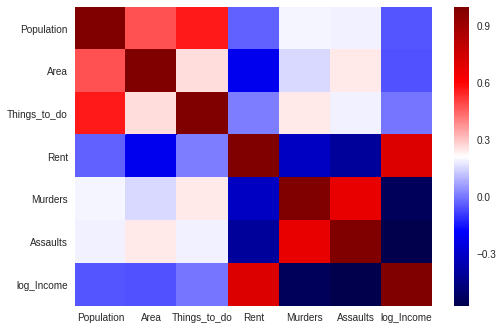

In [7]:
plt.style.use("seaborn")
sns.heatmap(df_all.corr(), cmap="seismic");

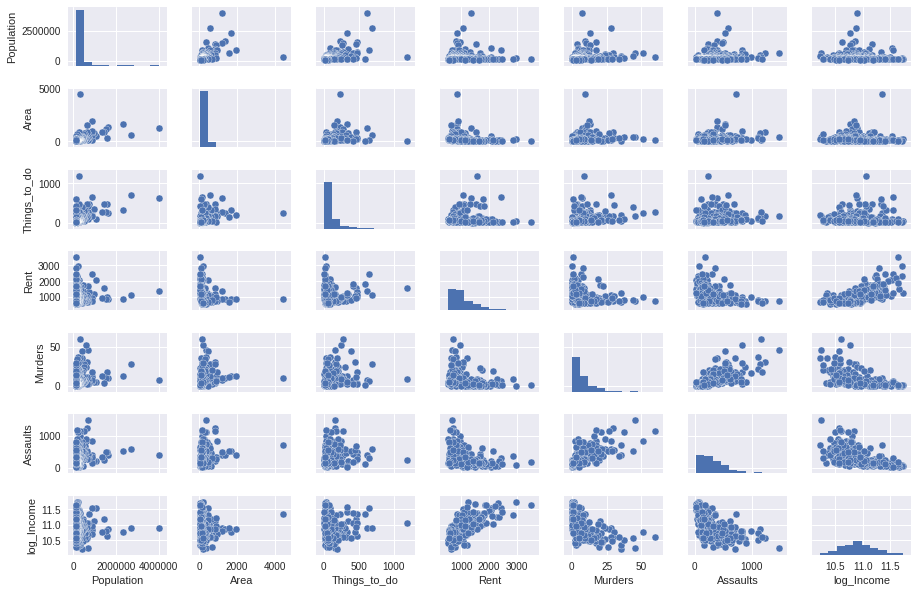

In [8]:
sns.pairplot(df_all, size = 1.2, aspect=1.5);

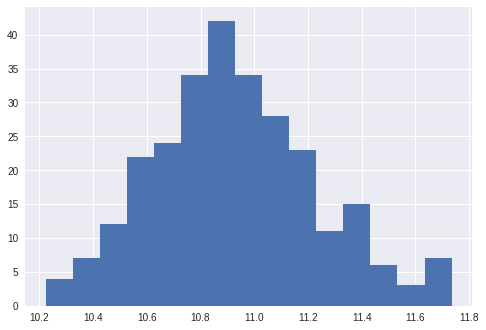

In [9]:
plt.hist(df_all.log_Income, bins = 15);

In [10]:
df_all.columns

Index(['Population', 'Area', 'Things_to_do', 'Rent', 'Murders', 'Assaults',
       'log_Income'],
      dtype='object')

In [11]:
#Removing high leverage points
df_all = df_all.drop([0,1,58,66])

In [12]:
df_all = df_all.reset_index()
df_all.head()

,index,Population,Area,Things_to_do,Rent,Murders,Assaults,log_Income
0,2,2312717,1651.1,332,841,12.9,534.9,10.774634
1,3,1626078,1340.6,239,836,9.2,394.7,10.860191
2,4,1580863,347.6,483,972,17.4,496.7,10.632219
3,5,1511946,1194.0,282,839,9.9,479.3,10.805030
4,6,1419516,842.3,463,1554,3.5,235.1,11.177187


In [13]:
df_all.drop("index",axis = 1,inplace=True)
df_all.head()

,Population,Area,Things_to_do,Rent,Murders,Assaults,log_Income
0,2312717,1651.1,332,841,12.9,534.9,10.774634
1,1626078,1340.6,239,836,9.2,394.7,10.860191
2,1580863,347.6,483,972,17.4,496.7,10.632219
3,1511946,1194.0,282,839,9.9,479.3,10.805030
4,1419516,842.3,463,1554,3.5,235.1,11.177187


In [14]:
#Making a simple degree one polynomial with no interaction
lm1 = smf.ols('log_Income ~ Population +  Area + Rent + Things_to_do + Murders + Assaults', data=df_all)

fit = lm1.fit()

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_Income   R-squared:                       0.671
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     88.85
Date:                Fri, 20 Jul 2018   Prob (F-statistic):           3.41e-60
Time:                        15:28:45   Log-Likelihood:                 85.570
No. Observations:                 268   AIC:                            -157.1
Df Residuals:                     261   BIC:                            -132.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       10.6251      0.042    255.841      0.000      10.543      10.707
Population   -9.432e-08   6.92e-08     -1.364      0.174    -2.3e-07    4.18e-08
Area             0.0002   6.84e-05      2.353      0.019    2.63e-05       0.000
Rent             0.0004   2.69e-05     14.166      0.000       0.000       0.000
Things_to_do     0.0003      0.000      2.696      0.007    9.17e-05       0.001
Murders         -0.0087      0.002     -5.187      0.000      -0.012      -0.005
Assaults        -0.0003    6.3e-05     -4.403      0.000      -0.000      -0.000
==============================================================================
Omnibus:                        6.152   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.046   Jarque-Bera (JB):                9.071
Skew:                           0.075   Prob(JB):                       0.0107
Kurtosis:                       3.889   Cond. No.                     1.45e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.45e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

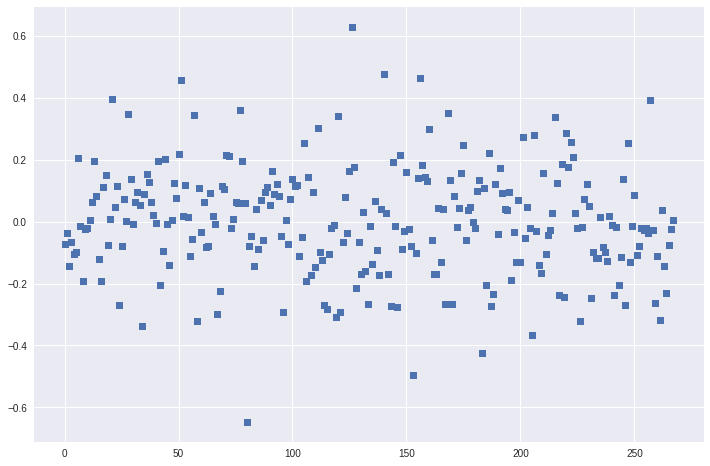

In [15]:
#Residual plot looks good
fit.resid.plot(style='s', figsize=(12,8));

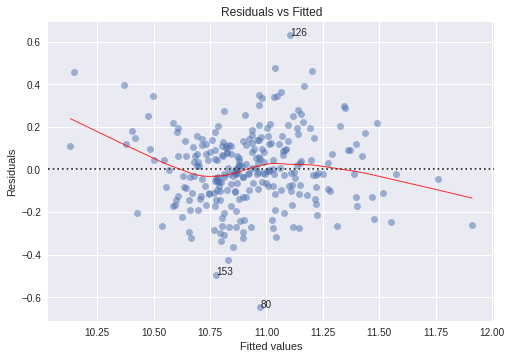

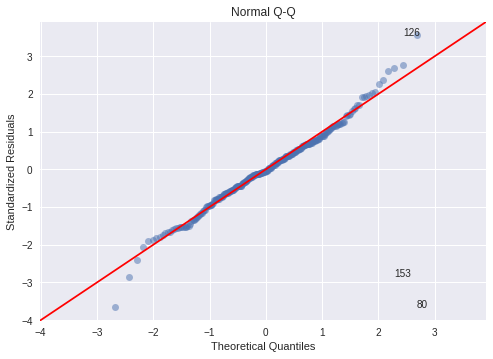

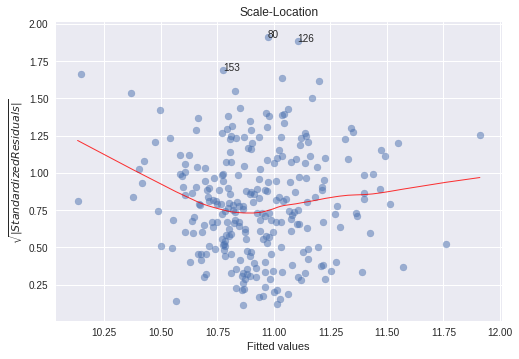

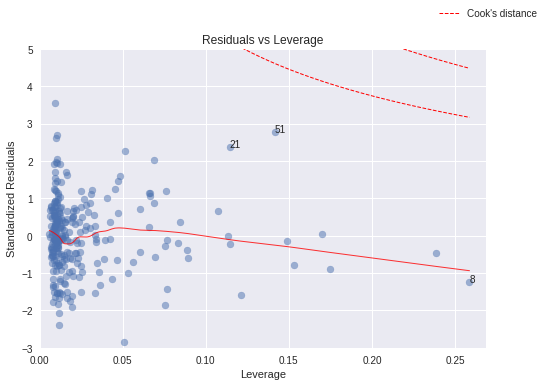

In [16]:
diagnostic_plots(df_all['Rent'], df_all['log_Income'], fit)

In [17]:
model_leverage = fit.get_influence().hat_matrix_diag
# cook's distance, from statsmodels internals
model_cooks = fit.get_influence().cooks_distance[0]


In [18]:
#Checking high leverage points
df_all.iloc[np.where(model_leverage > 0.25)]

,Population,Area,Things_to_do,Rent,Murders,Assaults,log_Income
8,892062,1935.8,187,874,12.0,388.2,10.845407


In [19]:
y = df_all["log_Income"]
X1 = df_all.drop(["log_Income"], axis = 1)

In [20]:
X1.columns

Index(['Population', 'Area', 'Things_to_do', 'Rent', 'Murders', 'Assaults'], dtype='object')

In [21]:
X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=8)

In [22]:
lr1 = make_pipeline(PolynomialFeatures(1), LinearRegression())
lr1.fit(X1_train, y_train)
lr1.score(X1_test, y_test)

0.6761065366376247

In [23]:
lr1.score(X1_train, y_train)

0.6661279244909314

## Scaling features and predictors

In [24]:
ssX = StandardScaler()
means_df_all = df_all.mean()
stds_df_all = df_all.std()
df_all_norm = pd.DataFrame(ssX.fit_transform(df_all))
X_norm = df_all_norm.iloc[:,:-1]
y_norm = df_all_norm.iloc[:,-1]
X_norm_columns = df_all.iloc[:,:-1].columns
X_norm.columns = X_norm_columns

In [25]:
X_norm_train, X_norm_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size=0.1, random_state=8)

In [26]:
#Cross validation with RIDGE and polynomial features

alphas = np.arange(14, 15, 0.01)
poly = PolynomialFeatures(2)
X_norm_train_poly = poly.fit_transform(X_norm_train)
Model_all = RidgeCV(cv=6, alphas=alphas)
Model_all.fit(X_norm_train, y_train)
y_pred_test = Model_all.predict(X_norm_test)
y_pred_train = Model_all.predict(X_norm_train)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

err_train = mean_squared_error(y_train, y_pred_train)
err_test = mean_squared_error(y_test, y_pred_test)

print("RESULTS WITH RIDGE_CV")
print("Alpha: " + str(Model_all.alpha_))
print("Variables: " +str(X_norm.columns))
print("Coefficients: " + str(Model_all.coef_))
print("Intercept: " + str(Model_all.intercept_))
print("r2_train: " + str(r2_train))
print("r2_test: " + str(r2_test))
print("error_train: " + str(err_train))
print("error_test: " + str(err_test))

RESULTS WITH RIDGE_CV
Alpha: 14.179999999999996
Variables: Index(['Population', 'Area', 'Things_to_do', 'Rent', 'Murders', 'Assaults'], dtype='object')
Coefficients: [-0.02523477  0.07014431  0.09713924  0.53243024 -0.2437856  -0.21386732]
Intercept: 0.017129117132814477
r2_train: 0.6786566379692467
r2_test: 0.5373063560780139
error_train: 0.31935582499759807
error_test: 0.45134442279920095


In [32]:
# Learning curves with Ridge
def learning_Ridge(X_train, y_train, X_test, y_test, order, alphas = 14.18 ):    
    poly = PolynomialFeatures(order)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.fit_transform(X_test)
    Model_all = Ridge(alphas)
    Model_all.fit(X_train_poly, y_train)
    y_pred_test = Model_all.predict(X_test_poly)
    y_pred_train = Model_all.predict(X_train_poly)
    
    err_train = mean_squared_error(y_train, y_pred_train)
    err_test = mean_squared_error(y_test, y_pred_test)
    
    return [err_train, err_test]

In [39]:
#Learning curves with Ridge for the alpha obtained with cv 
errors = []
sizes = []
groups = 30
for i in range(0, groups+1):
    end = int((i+1)*len(X_norm_train.iloc[:,0])/groups)
    errors.append(learning_Ridge(X_norm_train.iloc[0:end,:], y_train.iloc[0:end], X_norm_test, y_test, 2, 14.18))
    sizes.append(end)
#print(errors)
#print(sizes)

(0, 1)

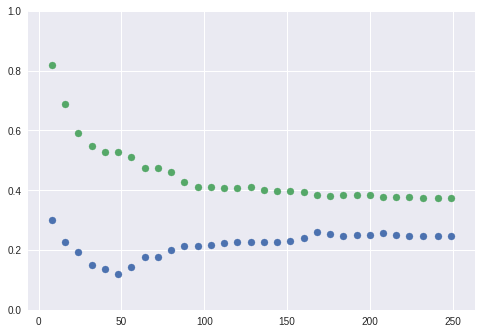

In [40]:
plt.scatter(sizes, [i[0] for i in errors])
plt.scatter(sizes, [i[1] for i in errors])
plt.ylim(0,1)

In [33]:
#Cross validation with LASSO with Polynomial
def LassoCV_poly(X_norm_train, y_train, X_norm_test, y_test, order, alphas, cvs):
    poly = PolynomialFeatures(order)
    X_norm_train_poly = poly.fit_transform(X_norm_train)
    X_norm_test_poly = poly.fit_transform(X_norm_test)
    Model_all = LassoCV(cv=cvs, alphas=alphas)
    Model_all.fit(X_norm_train_poly, y_train)
    y_pred_test = Model_all.predict(X_norm_test_poly)
    y_pred_train = Model_all.predict(X_norm_train_poly)

    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)

    err_train = mean_squared_error(y_train, y_pred_train)
    err_test = mean_squared_error(y_test, y_pred_test)

    print("RESULTS WITH LASSO_CV")
    print("Polinomial order " + str(order))
    print("Alpha: " + str(Model_all.alpha_))
    print("Variables: " +str(X_norm_train.columns))
    #print("Coefficients: " + str(Model_all.coef_))
    print("Coefficients: ")
    coef_pow = [(i,j) for i,j in zip(poly.powers_, Model_all.coef_)]
    [print(str(i)) for i in coef_pow]
    print("Intercept: " + str(Model_all.intercept_))
    print("r2_train: " + str(r2_train))
    print("r2_test: " + str(r2_test))
    print("error_train: " + str(err_train))
    print("error_test: " + str(err_test))
    
    return [Model_all.intercept_,Model_all.coef_]

In [34]:
alphas = np.arange(0, 1, 0.0001)
LassoCV_poly(X_norm_train, y_train, X_norm_test, y_test, 2, alphas, 6)

RESULTS WITH LASSO_CV
Polinomial order 2
Alpha: 0.0281
Variables: Index(['Population', 'Area', 'Things_to_do', 'Rent', 'Murders', 'Assaults'], dtype='object')
Coefficients: 
(array([0, 0, 0, 0, 0, 0]), 0.0)
(array([1, 0, 0, 0, 0, 0]), 0.0)
(array([0, 1, 0, 0, 0, 0]), 0.06341717541593823)
(array([0, 0, 1, 0, 0, 0]), 0.047512243510726436)
(array([0, 0, 0, 1, 0, 0]), 0.5429938462615913)
(array([0, 0, 0, 0, 1, 0]), -0.294138902547678)
(array([0, 0, 0, 0, 0, 1]), -0.33329804872446894)
(array([2, 0, 0, 0, 0, 0]), -0.004585069545470466)
(array([1, 1, 0, 0, 0, 0]), -0.0)
(array([1, 0, 1, 0, 0, 0]), -0.009780688947181683)
(array([1, 0, 0, 1, 0, 0]), 0.0)
(array([1, 0, 0, 0, 1, 0]), -0.0)
(array([1, 0, 0, 0, 0, 1]), -0.0)
(array([0, 2, 0, 0, 0, 0]), 0.0)
(array([0, 1, 1, 0, 0, 0]), -0.0)
(array([0, 1, 0, 1, 0, 0]), -0.0)
(array([0, 1, 0, 0, 1, 0]), -0.0)
(array([0, 1, 0, 0, 0, 1]), 0.010103110684628406)
(array([0, 0, 2, 0, 0, 0]), 0.017570371017769804)
(array([0, 0, 1, 1, 0, 0]), 0.0)
(array([0,

[-0.07573545280608542,
 array([ 0.        ,  0.        ,  0.06341718,  0.04751224,  0.54299385,
        -0.2941389 , -0.33329805, -0.00458507, -0.        , -0.00978069,
         0.        , -0.        , -0.        ,  0.        , -0.        ,
        -0.        , -0.        ,  0.01010311,  0.01757037,  0.        ,
         0.03040296,  0.        , -0.02580363,  0.        , -0.        ,
         0.00639306,  0.        ,  0.09604489])]

In [41]:
#Learning curve for LASSO with Polynomial
def learning_Lasso(order, X_train, y_train, X_test, y_test, alphas = 0.0281):    
    poly = PolynomialFeatures(order)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.fit_transform(X_test)
    Model_all = Lasso(alphas)
    Model_all.fit(X_train_poly, y_train)
    y_pred_test = Model_all.predict(X_test_poly)
    y_pred_train = Model_all.predict(X_train_poly)
    
    err_train = mean_squared_error(y_train, y_pred_train)
    err_test = mean_squared_error(y_test, y_pred_test)
    
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)

    
    return [err_train, err_test, r2_train, r2_test]

In [42]:
#Learning curves with Lasso for the alpha obtained with cv 
errors = []
sizes = []
groups = 10
for i in range(0, groups+1):
    end = int((i+1)*len(X_norm_train.iloc[:,0])/groups)
    errors.append(learning_Lasso(3, X_norm_train.iloc[0:end,:], y_train.iloc[0:end], X_norm_test, y_test, 0.0281))
    sizes.append(end)
#print(errors)
#print(sizes)

(0, 1)

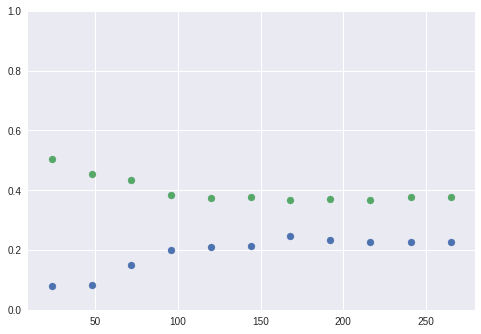

In [43]:
plt.scatter(sizes, [i[0] for i in errors])
plt.scatter(sizes, [i[1] for i in errors])
plt.ylim(0,1)

In [49]:
#cross validation with ElasticNet
alphas = np.arange(0.01, 1, 0.01)
l1_ratios = np.arange(0.1, 0.3, 0.01)
Model_all = ElasticNetCV(cv=6, random_state=0, alphas=alphas, l1_ratio=l1_ratios)
Model_all.fit(X_norm_train, y_train)
y_pred_test = Model_all.predict(X_norm_test)
y_pred_train = Model_all.predict(X_norm_train)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

err_train = mean_squared_error(y_train, y_pred_train)
err_test = mean_squared_error(y_test, y_pred_test)

print("RESULTS WITH ELASTIC_NET_CV")
print("Alpha: " + str(Model_all.alpha_))
print("l1_ratio: " + str(Model_all.l1_ratio_))
print("Variables: " +str(X_norm.columns))
print("Coefficients: " + str(Model_all.coef_))
print("Intercept: " + str(Model_all.intercept_))
print("r2_train: " + str(r2_train))
print("r2_test: " + str(r2_test))
print("error_train: " + str(err_train))
print("error_test: " + str(err_test))

RESULTS WITH ELASTIC_NET_CV
Alpha: 0.05
l1_ratio: 0.20999999999999996
Variables: Index(['Population', 'Area', 'Things_to_do', 'Rent', 'Murders', 'Assaults'], dtype='object')
Coefficients: [-0.          0.04644342  0.08089789  0.53097088 -0.23927781 -0.20736238]
Intercept: 0.017750300297034408
r2_train: 0.6773984421260532
r2_test: 0.5275241478646504
error_train: 0.32060623878854233
error_test: 0.46088668727108245


In [50]:
def learning_ElasticNet(X_train, y_train, X_test, y_test, alpha = 0.05, l1_ratio=0.21):    
    Model_all = ElasticNet(random_state=0, alpha=alpha, l1_ratio=l1_ratio)
    Model_all.fit(X_train, y_train)
    y_pred_test = Model_all.predict(X_test)
    y_pred_train = Model_all.predict(X_train)
    
    err_train = mean_squared_error(y_train, y_pred_train)
    err_test = mean_squared_error(y_test, y_pred_test)
    
    return [err_train, err_test]

In [52]:
#Learning curves with ElasticNet for the alpha obtained with cv 
errors = []
sizes = []
groups = 10
for i in range(0, groups+1):
    end = int((i+1)*len(X_norm_train.iloc[:,0])/groups)
    errors.append(learning_ElasticNet(X_norm_train.iloc[0:end,:], y_train.iloc[0:end], X_norm_test, y_test))
    sizes.append(end)
#print(errors)
#print(sizes)

(0, 1)

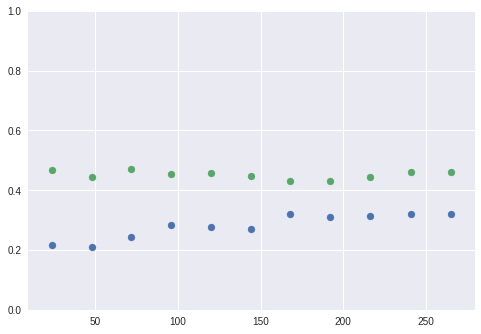

In [53]:
plt.scatter(sizes, [i[0] for i in errors])
plt.scatter(sizes, [i[1] for i in errors])
plt.ylim(0,1)

## Trying Lasso with polinomial features manually (Outdated)

In [ ]:
errors_r2 = []
alphas = []
alphas_tried = np.arange(0, 1, 0.001)
for alpha in alphas_tried:
    errors_r2.append(learning_Lasso(2, X_norm_train, y_train, X_norm_test, y_test, alphas = alpha))
    alphas.append(alpha)

In [ ]:
plt.scatter(alphas, [i[0] for i in errors_r2])
plt.scatter(alphas, [i[1] for i in errors_r2])
plt.title("Mean Square Errors")

In [ ]:
plt.scatter(alphas, [i[2] for i in errors_r2])
plt.scatter(alphas, [i[3] for i in errors_r2])
plt.ylim(0,1)

In [ ]:
plt.scatter(alphas, [abs(i[3]-i[2]) for i in errors_r2])
plt.ylim(0,1)
print(min([abs(i[3]-i[2]) for i in errors_r2]))

## Different polinomial models with LassoCV

In [60]:
col_selector = ['Population', 'Area', 'Things_to_do', 'Rent', 'Murders', 'Assaults']
X_norm_train1 = X_norm_train[col_selector]
X_norm_test1 = X_norm_test[col_selector]

In [61]:
cv=6

### Order 1

In [56]:
alphas = np.arange(0, 1, 0.0001)
LassoCV_poly(X_norm_train1, y_train, X_norm_test1, y_test, 1, alphas, cv);

RESULTS WITH LASSO_CV
Polinomial order 1
Alpha: 0.014100000000000001
Variables: Index(['Population', 'Area', 'Things_to_do', 'Rent', 'Murders', 'Assaults'], dtype='object')
Coefficients: 
(array([0, 0, 0, 0, 0, 0]), 0.0)
(array([1, 0, 0, 0, 0, 0]), -0.0)
(array([0, 1, 0, 0, 0, 0]), 0.04995070405636935)
(array([0, 0, 1, 0, 0, 0]), 0.07972771157981849)
(array([0, 0, 0, 1, 0, 0]), 0.5493466809264034)
(array([0, 0, 0, 0, 1, 0]), -0.24225942151967295)
(array([0, 0, 0, 0, 0, 1]), -0.2027749680337722)
Intercept: 0.017204422236448722
r2_train: 0.6782525648413826
r2_test: 0.5321973953007333
error_train: 0.3197573988975315
error_test: 0.4563280679895253


### Order 2

In [57]:
alphas = np.arange(0, 1, 0.0001)
LassoCV_poly(X_norm_train1, y_train, X_norm_test1, y_test, 2, alphas, cv);

RESULTS WITH LASSO_CV
Polinomial order 2
Alpha: 0.0281
Variables: Index(['Population', 'Area', 'Things_to_do', 'Rent', 'Murders', 'Assaults'], dtype='object')
Coefficients: 
(array([0, 0, 0, 0, 0, 0]), 0.0)
(array([1, 0, 0, 0, 0, 0]), 0.0)
(array([0, 1, 0, 0, 0, 0]), 0.06341717541593823)
(array([0, 0, 1, 0, 0, 0]), 0.047512243510726436)
(array([0, 0, 0, 1, 0, 0]), 0.5429938462615913)
(array([0, 0, 0, 0, 1, 0]), -0.294138902547678)
(array([0, 0, 0, 0, 0, 1]), -0.33329804872446894)
(array([2, 0, 0, 0, 0, 0]), -0.004585069545470466)
(array([1, 1, 0, 0, 0, 0]), -0.0)
(array([1, 0, 1, 0, 0, 0]), -0.009780688947181683)
(array([1, 0, 0, 1, 0, 0]), 0.0)
(array([1, 0, 0, 0, 1, 0]), -0.0)
(array([1, 0, 0, 0, 0, 1]), -0.0)
(array([0, 2, 0, 0, 0, 0]), 0.0)
(array([0, 1, 1, 0, 0, 0]), -0.0)
(array([0, 1, 0, 1, 0, 0]), -0.0)
(array([0, 1, 0, 0, 1, 0]), -0.0)
(array([0, 1, 0, 0, 0, 1]), 0.010103110684628406)
(array([0, 0, 2, 0, 0, 0]), 0.017570371017769804)
(array([0, 0, 1, 1, 0, 0]), 0.0)
(array([0,

### Order 3

In [58]:
alphas = np.arange(0, 1, 0.0001)
LassoCV_poly(X_norm_train1, y_train, X_norm_test1, y_test, 3, alphas, cv);

RESULTS WITH LASSO_CV
Polinomial order 3
Alpha: 0.0371
Variables: Index(['Population', 'Area', 'Things_to_do', 'Rent', 'Murders', 'Assaults'], dtype='object')
Coefficients: 
(array([0, 0, 0, 0, 0, 0]), 0.0)
(array([1, 0, 0, 0, 0, 0]), 0.02195070011917508)
(array([0, 1, 0, 0, 0, 0]), 0.0)
(array([0, 0, 1, 0, 0, 0]), 0.0004595209679829928)
(array([0, 0, 0, 1, 0, 0]), 0.4389858917878906)
(array([0, 0, 0, 0, 1, 0]), -0.2895962173242942)
(array([0, 0, 0, 0, 0, 1]), -0.2876741057943913)
(array([2, 0, 0, 0, 0, 0]), 0.0)
(array([1, 1, 0, 0, 0, 0]), 0.0)
(array([1, 0, 1, 0, 0, 0]), -0.0)
(array([1, 0, 0, 1, 0, 0]), -0.0)
(array([1, 0, 0, 0, 1, 0]), 0.0)
(array([1, 0, 0, 0, 0, 1]), 0.0)
(array([0, 2, 0, 0, 0, 0]), 0.0)
(array([0, 1, 1, 0, 0, 0]), -0.0)
(array([0, 1, 0, 1, 0, 0]), -0.0)
(array([0, 1, 0, 0, 1, 0]), 0.0)
(array([0, 1, 0, 0, 0, 1]), 0.0)
(array([0, 0, 2, 0, 0, 0]), 0.017524264299115726)
(array([0, 0, 1, 1, 0, 0]), -0.0)
(array([0, 0, 1, 0, 1, 0]), -0.0)
(array([0, 0, 1, 0, 0, 1]), 0

### Order 4

In [59]:
alphas = np.arange(0, 1, 0.0001)
LassoCV_poly(X_norm_train1, y_train, X_norm_test1, y_test, 4, alphas, cv);

RESULTS WITH LASSO_CV
Polinomial order 4
Alpha: 0.13820000000000002
Variables: Index(['Population', 'Area', 'Things_to_do', 'Rent', 'Murders', 'Assaults'], dtype='object')
Coefficients: 
(array([0, 0, 0, 0, 0, 0]), 0.0)
(array([1, 0, 0, 0, 0, 0]), 0.0)
(array([0, 1, 0, 0, 0, 0]), 0.0)
(array([0, 0, 1, 0, 0, 0]), 0.0)
(array([0, 0, 0, 1, 0, 0]), 0.41406315606082666)
(array([0, 0, 0, 0, 1, 0]), -0.013500660536383513)
(array([0, 0, 0, 0, 0, 1]), -0.18362532814580448)
(array([2, 0, 0, 0, 0, 0]), 0.0)
(array([1, 1, 0, 0, 0, 0]), 0.0)
(array([1, 0, 1, 0, 0, 0]), -0.0)
(array([1, 0, 0, 1, 0, 0]), -0.0)
(array([1, 0, 0, 0, 1, 0]), 0.0)
(array([1, 0, 0, 0, 0, 1]), 0.0)
(array([0, 2, 0, 0, 0, 0]), 0.0)
(array([0, 1, 1, 0, 0, 0]), 0.0)
(array([0, 1, 0, 1, 0, 0]), -0.0)
(array([0, 1, 0, 0, 1, 0]), 0.0)
(array([0, 1, 0, 0, 0, 1]), 0.0)
(array([0, 0, 2, 0, 0, 0]), 0.0)
(array([0, 0, 1, 1, 0, 0]), -0.0)
(array([0, 0, 1, 0, 1, 0]), 0.0)
(array([0, 0, 1, 0, 0, 1]), 0.0)
(array([0, 0, 0, 2, 0, 0]), -0.0

## Polynomial order 3 and 2 are considered. Making fit with all data.

In [63]:
def single_Lasso_alldata(order, X, y, alphas = 0.0139):    
    poly = PolynomialFeatures(order)
    X_poly = poly.fit_transform(X)
    Model_all = Lasso(alphas)
    Model_all.fit(X_poly, y)
    y_pred = Model_all.predict(X_poly)

    err_out = mean_squared_error(y, y_pred)

    r2_out = r2_score(y, y_pred)

    
    return err_out, r2_out, y_pred, Model_all.coef_, Model_all.intercept_, poly.powers_

In [64]:
err_out, r2_out, y_pred, coef, interc, powers  = single_Lasso_alldata(3, X_norm, y_norm, 0.0371);
print(err_out, r2_out)

0.25051765127273107 0.7494823487272689


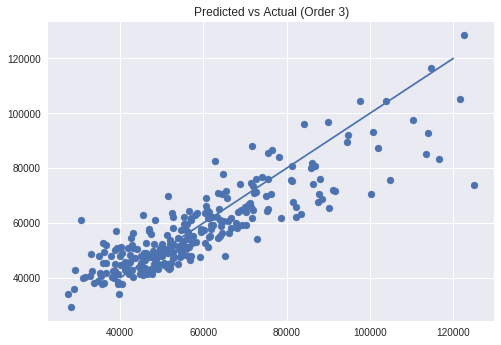

In [65]:
y_norm_dol = np.exp((y_norm*stds_df_all[-1]) + means_df_all[-1])
y_pred_dol = np.exp((y_pred*stds_df_all[-1]) + means_df_all[-1])
plt.scatter(y_norm_dol, y_pred_dol)
plt.title("Predicted vs Actual (Order 3)")
plt.plot(np.arange(40000,121000,1000),np.arange(40000,121000,1000))

9435.735678428613


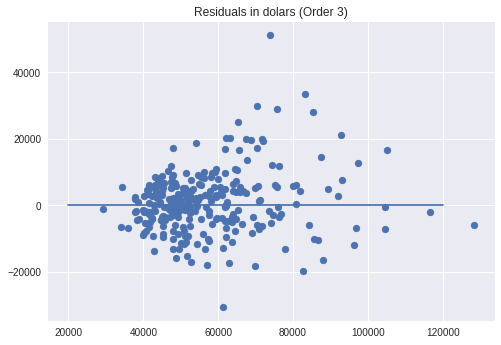

In [66]:
counter = np.arange(1, len(y_norm) + 1, 1)
plt.scatter(y_pred_dol, y_norm_dol-y_pred_dol)
plt.plot([20000,120000],[0,0])
plt.title("Residuals in dolars (Order 3)")
print((y_norm_dol-y_pred_dol).std())

In [67]:
err_out, r2_out, y_pred, coef, interc, powers  = single_Lasso_alldata(2, X_norm, y_norm, 0.0281);
print(err_out, r2_out)

0.2747324166798858 0.7252675833201142


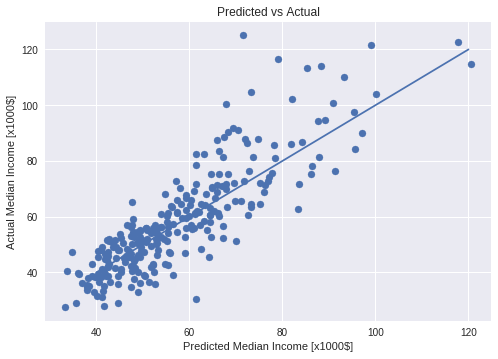

In [68]:
y_norm_dol = np.exp((y_norm*stds_df_all[-1]) + means_df_all[-1])
y_pred_dol = np.exp((y_pred*stds_df_all[-1]) + means_df_all[-1])
plt.scatter(y_pred_dol/1000,y_norm_dol/1000,)
plt.plot(np.arange(40,121,1),np.arange(40,121,1))
plt.title("Predicted vs Actual")
plt.ylabel("Actual Median Income [x1000$]" )
plt.xlabel("Predicted Median Income [x1000$]" )
plt.savefig("Actual_vs_Pred.jpg",dpi = 300)

9984.99713775581


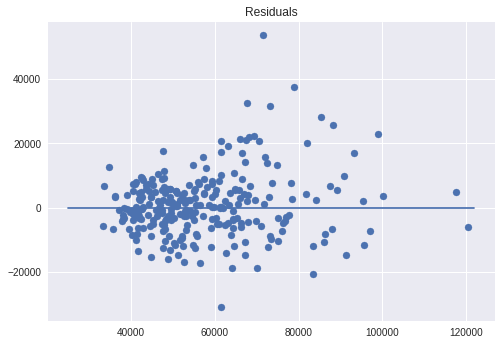

In [69]:
counter = np.arange(1,len(y_norm)+1,1)
plt.scatter(y_pred_dol, y_norm_dol - y_pred_dol)
plt.plot([25000,122000],[0,0])
plt.title("Residuals")
print(np.sqrt(mean_squared_error(y_norm_dol,y_pred_dol)))
plt.savefig('Residuals.jpg',dpi = 300)

## Using Lasso to predict points

In [70]:
def predictor_Lasso_order_2(X_question, X, y):    
    poly = PolynomialFeatures(2)
    X_poly = poly.fit_transform(X)
    Model_all = Lasso(0.0281)
    Model_all.fit(X_poly, y)
    
    X_formated = np.divide((X_question-np.array(means_df_all[:-1])),np.array(stds_df_all[:-1]))
    X_formated = poly.fit_transform(X_formated)
    y_ans = Model_all.predict(X_formated)
    y_ans_dol = np.exp((y_ans*stds_df_all[-1]) + means_df_all[-1])
    
    return y_ans_dol

In [71]:
df_all.columns

Index(['Population', 'Area', 'Things_to_do', 'Rent', 'Murders', 'Assaults',
       'log_Income'],
      dtype='object')

In [72]:
X_question = np.array([[150000, 100, 300,900,18,500],
                       [150000, 300, 100,900,18,500],
                       [150000, 300, 700,900,18,500],
                       [150000,  50, 500,900,18,500],
                       [150000, 200, 500,900,18,500],
                       [600000, 300, 500,900,18,500],
                       [ 50000, 300, 500,900,18,500],
                       [150000, 300, 500,1500,18,500],
                       [150000, 300, 500,600,18,500],
                       [150000, 300, 500,900,18,500],
                       [150000, 300, 500,900,10,500],
                       [150000, 300, 500,900,30,500],
                       [150000, 300, 500,900,18,200],
                       [150000, 300, 500,900,18,800],
                       ])

In [73]:
print(predictor_Lasso_order_2(X_question, X_norm, y_norm))


[44799.90682432 43279.0676674  57229.27505505 48957.48925251
 49605.90826814 49777.99760717 50037.37473095 61517.87668069
 44797.10761673 50042.95173599 52951.81650434 46380.86791964
 56586.85796899 48457.19202447]


## Learning curves for Lasso orders 2, 3 and 4 

In [74]:
errors = []
sizes = []
groups = 5
for i in range(0, groups+1):
    end = int((i+1)*len(X_norm_train.iloc[:,0])/groups)
    errors.append(learning_Lasso(1, X_norm_train.iloc[0:end,:], y_train.iloc[0:end], X_norm_test, y_test, 0.0141))
    sizes.append(end)

Text(0.5,1,'Mean squared errors for train and test sets')

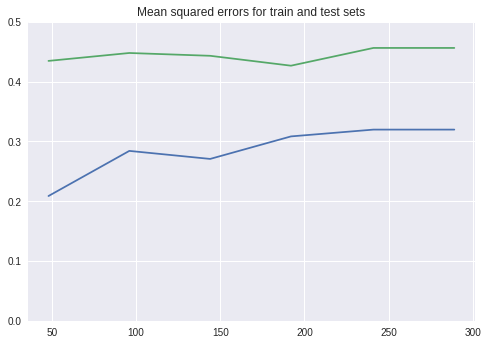

In [75]:
plt.plot(sizes, [i[0] for i in errors])
plt.plot(sizes, [i[1] for i in errors])
plt.ylim(0,0.5)
plt.title("Mean squared errors for train and test sets")

Text(0.5,1,'R² for train and test sets')

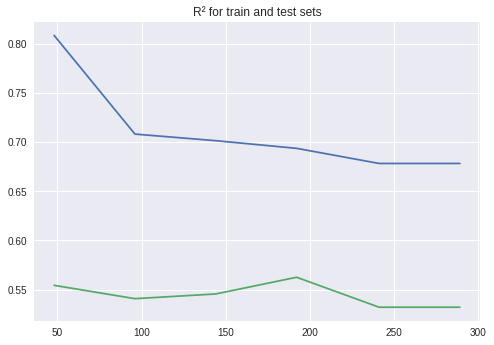

In [76]:
plt.plot(sizes, [i[2] for i in errors])
plt.plot(sizes, [i[3] for i in errors])
#plt.ylim(0,1)
plt.title("R² for train and test sets")

In [77]:
errors = []
sizes = []
groups = 5
for i in range(0, groups+1):
    end = int((i+1)*len(X_norm_train.iloc[:,0])/groups)
    errors.append(learning_Lasso(2, X_norm_train.iloc[0:end,:], y_train.iloc[0:end], X_norm_test, y_test, 0.0281))
    sizes.append(end)

0.38556640679178633


Text(0.5,1,'Mean squared errors for train and test sets')

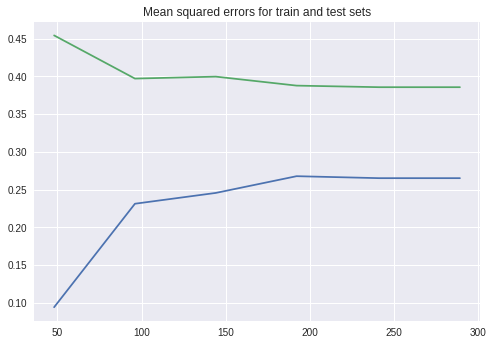

In [78]:
print(errors[-1][1])
plt.plot(sizes, [i[0] for i in errors])
plt.plot(sizes, [i[1] for i in errors])
#plt.ylim(0,0.5)
plt.title("Mean squared errors for train and test sets")

Text(0.5,1,'R² for train and test sets')

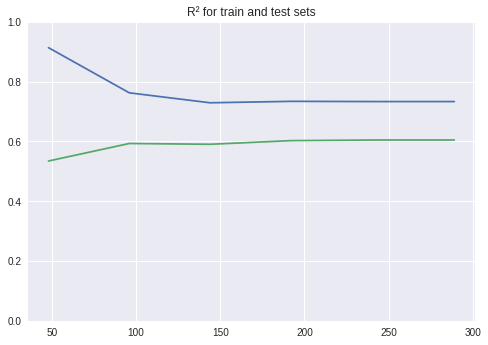

In [79]:
plt.plot(sizes, [i[2] for i in errors])
plt.plot(sizes, [i[3] for i in errors])
plt.ylim(0,1)
plt.title("R² for train and test sets")

In [80]:
errors = []
sizes = []
groups = 5
for i in range(0, groups+1):
    end = int((i+1)*len(X_norm_train.iloc[:,0])/groups)
    errors.append(learning_Lasso(3, X_norm_train.iloc[0:end,:], y_train.iloc[0:end], X_norm_test, y_test, 0.0371))
    sizes.append(end)

0.38676367121407984


Text(0.5,1,'Mean squared errors for train and test sets')

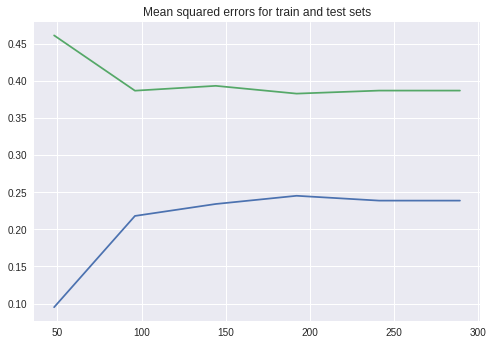

In [81]:
print(errors[-1][1])
plt.plot(sizes, [i[0] for i in errors])
plt.plot(sizes, [i[1] for i in errors])
#plt.ylim(0,10)
plt.title("Mean squared errors for train and test sets")

Text(0.5,1,'R² for train and test sets')

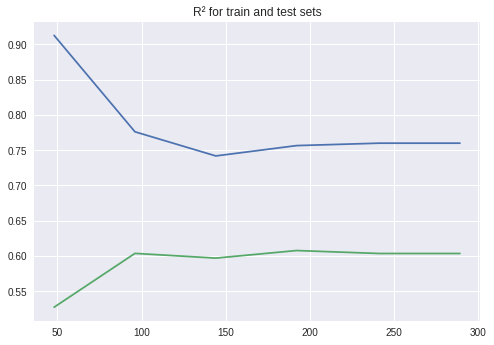

In [82]:
plt.plot(sizes, [i[2] for i in errors])
plt.plot(sizes, [i[3] for i in errors])
#plt.ylim(0,1)
plt.title("R² for train and test sets")

In [83]:
errors = []
sizes = []
groups = 5
for i in range(0, groups+1):
    end = int((i+1)*len(X_norm_train.iloc[:,0])/groups)
    errors.append(learning_Lasso(4, X_norm_train.iloc[0:end,:], y_train.iloc[0:end], X_norm_test, y_test, 0.1074))
    sizes.append(end)


Text(0.5,1,'Mean squared errors for train and test sets')

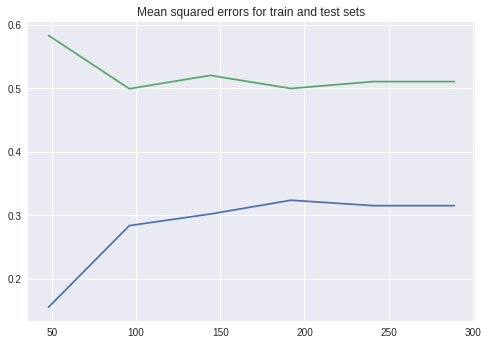

In [84]:
plt.plot(sizes, [i[0] for i in errors])
plt.plot(sizes, [i[1] for i in errors])
#plt.ylim(0,0.5)
plt.title("Mean squared errors for train and test sets")

Text(0.5,1,'R² for train and test sets')

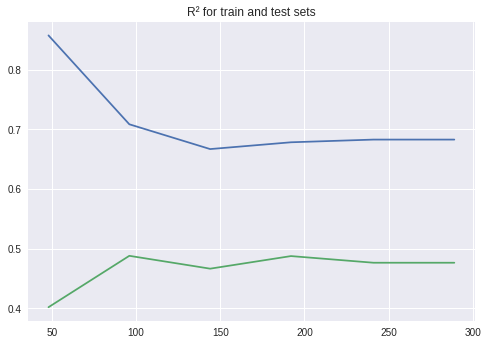

In [85]:
plt.plot(sizes, [i[2] for i in errors])
plt.plot(sizes, [i[3] for i in errors])
#plt.ylim(0,1)
plt.title("R² for train and test sets")